# 验证环境

In [1]:
import torch

print("Pytorch Version: ", torch.__version__)

if torch.cuda.is_available():
    print("CUDA Version: ", torch.version.cuda)
    print("Device Num: ", torch.cuda.device_count())
    print("Device Name: ", torch.cuda.get_device_name())

Pytorch Version:  1.12.1+cu116
CUDA Version:  11.6
Device Num:  1
Device Name:  NVIDIA GeForce RTX 4090


In [2]:
import tensorflow as tf
 
print("TensorFlow version:", tf.__version__)
 
# 检查TensorFlow是否配置为使用GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU(s)")
else:
    print("TensorFlow is using CPU")

2024-11-14 13:41:32.444911: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 13:41:32.473497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 13:41:32.800189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.0
TensorFlow is using GPU(s)


2024-11-14 13:41:33.313922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 13:41:33.329840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 13:41:33.330491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# 提取waymo原始场景信息

In [ ]:
import os
from argparse import ArgumentParser
from tqdm import tqdm
from pathlib import Path
import tensorflow as tf
import pickle
from waymo_open_dataset.protos import scenario_pb2

out_dir = Path("/media/yangyh408/4A259082626F01B9/smart_waymo_processed/val_scenarios")

tfrecord_files = sorted([p.as_posix() for p in Path("/media/yangyh408/4A259082626F01B9/womd_scenario_v_1_2_0/validation").glob("*")])
assert len(tfrecord_files) == 150, "Validation tfrecord not complete, please dowload womd_scenario_v_1_2_0!"
tf.config.set_visible_devices([], "GPU")
tf_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type="")
dataset_iterator = tf_dataset.as_numpy_iterator()
for i, scenario_bytes in enumerate(dataset_iterator):
    scenario = scenario_pb2.Scenario.FromString(bytes.fromhex(scenario_bytes.hex()))
    with open(out_dir / f"{scenario.scenario_id}.pickle", "wb") as handle:
        pickle.dump(scenario_bytes, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(i)

# 分步调用模型

In [3]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from argparse import ArgumentParser
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader
from smart.datasets.scalable_dataset import MultiDataset
from smart.model import SMART
from smart.transforms import WaymoTargetBuilder
from smart.utils.config import load_config_act
from smart.utils.log import Logging

## 加载配置文件

In [6]:
config = load_config_act("../configs/validation/validation_scalable.yaml")

## 加载模型

In [7]:
pretrain_ckpt = "../ckpt/20241021_1037/epoch=07-step=30440-val_loss=2.52.ckpt"
Predictor = SMART
logger = Logging().log(level='DEBUG')
model = Predictor(config.Model)
model.load_params_from_file(filename=pretrain_ckpt, logger=logger)
model.eval()

2024-11-14 13:42:52,339-INFO-smart.py-Line:222-Message:==> Loading parameters from checkpoint ../ckpt/20241021_1037/epoch=07-step=30440-val_loss=2.52.ckpt to GPU
2024-11-14 13:42:56,814-INFO-smart.py-Line:231-Message:The number of disk ckpt keys: 818
2024-11-14 13:42:56,872-INFO-smart.py-Line:247-Message:Missing keys: []
2024-11-14 13:42:56,872-INFO-smart.py-Line:248-Message:The number of missing keys: 0
2024-11-14 13:42:56,873-INFO-smart.py-Line:249-Message:The number of unexpected keys: 0
2024-11-14 13:42:56,873-INFO-smart.py-Line:250-Message:==> Done (total keys 818)


SMART(
  (encoder): SMARTDecoder(
    (map_encoder): SMARTMapDecoder(
      (type_pt_emb): Embedding(17, 128)
      (side_pt_emb): Embedding(4, 128)
      (polygon_type_emb): Embedding(4, 128)
      (light_pl_emb): Embedding(4, 128)
      (r_pt2pt_emb): FourierEmbedding(
        (freqs): Embedding(3, 64)
        (mlps): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=129, out_features=128, bias=True)
            (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (2): ReLU(inplace=True)
            (3): Linear(in_features=128, out_features=128, bias=True)
          )
          (1): Sequential(
            (0): Linear(in_features=129, out_features=128, bias=True)
            (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (2): ReLU(inplace=True)
            (3): Linear(in_features=128, out_features=128, bias=True)
          )
          (2): Sequential(
            (0): Linear(in_features=129, out_features=128, bias=Tru

## 加载数据

In [8]:
data_config = config.Dataset
val_dataset = {
    "scalable": MultiDataset,
}[data_config.dataset](root=data_config.root, split='val',
                        raw_dir=data_config.val_raw_dir,
                        processed_dir=data_config.val_processed_dir,
                        transform=WaymoTargetBuilder(config.Model.num_historical_steps, config.Model.decoder.num_future_steps))
dataloader = DataLoader(val_dataset, batch_size=data_config.batch_size, shuffle=False, num_workers=data_config.num_workers,
                        pin_memory=data_config.pin_memory, persistent_workers=True if data_config.num_workers > 0 else False)

2024-11-14 13:43:01,834-DEBUG-scalable_dataset.py-Line:38-Message:Starting loading dataset with MultiDataset
2024-11-14 13:43:12,761-DEBUG-scalable_dataset.py-Line:62-Message:The number of val dataset is 44097


In [9]:
data_iter = iter(dataloader)
batch = next(data_iter)
batch

HeteroDataBatch(
  scenario_id=[1],
  agent={
    num_nodes=24,
    av_index=[1],
    valid_mask=[24, 91],
    predict_mask=[24, 91],
    id=[1],
    type=[24],
    category=[24],
    position=[24, 91, 3],
    heading=[24, 91],
    velocity=[24, 91, 3],
    shape=[24, 91, 3],
    token_idx=[24, 18],
    token_contour=[24, 18, 4, 2],
    token_pos=[24, 18, 2],
    token_heading=[24, 18],
    agent_valid_mask=[24, 18],
    token_velocity=[24, 18, 2],
    batch=[24],
    ptr=[2],
  },
  map_polygon={
    num_nodes=56,
    type=[56],
    light_type=[56],
    batch=[56],
    ptr=[2],
  },
  map_point={
    num_nodes=11549,
    position=[11549, 3],
    orientation=[11549],
    magnitude=[11549],
    height=[11549],
    type=[11549],
    batch=[11549],
    ptr=[2],
  },
  map_save={
    traj_pos=[1153, 3, 2],
    traj_theta=[1153],
    pl_idx_list=[1153],
  },
  pt_token={
    type=[1153],
    side=[1153],
    pl_type=[1153],
    num_nodes=1153,
    batch=[1153],
    ptr=[2],
  },
  (map_poin

In [ ]:
from smart.datasets.preprocess import TokenProcessor  
import os  
import pickle
import shutil

raw_dir = "/media/yangyh408/4A259082626F01B9/smart_waymo_processed/raw/validation"
for file in os.listdir(raw_dir):
    with open(os.path.join(raw_dir, file), 'rb') as handle:
        raw_data = pickle.load(handle)
    break

In [55]:
token_processor = TokenProcessor(2048) 
process_data = token_processor.preprocess(raw_data)

In [56]:
for i in range(5, 91, 5):
    print(i)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90


# 提取场景信息

In [28]:
import os
import pickle

In [26]:
smart_raw_dir = "/media/yangyh408/4A259082626F01B9/smart_waymo_processed/raw/validation"

In [33]:
for f in os.listdir(smart_raw_dir):
    with open(os.path.join(smart_raw_dir, f), 'rb') as handle:
        raw_data = pickle.load(handle)
    break

for k, v in raw_data.items():
    print(k, type(v))
    if isinstance(v, dict):
        for kk, vv in v.items():
            print(f"  {k} {type(v)}")

scenario_id <class 'str'>
city <class 'numpy.float64'>
agent <class 'dict'>
  agent <class 'dict'>
  agent <class 'dict'>
  agent <class 'dict'>
  agent <class 'dict'>
  agent <class 'dict'>
  agent <class 'dict'>
  agent <class 'dict'>
  agent <class 'dict'>
  agent <class 'dict'>
  agent <class 'dict'>
  agent <class 'dict'>
map_polygon <class 'dict'>
  map_polygon <class 'dict'>
  map_polygon <class 'dict'>
  map_polygon <class 'dict'>
map_point <class 'dict'>
  map_point <class 'dict'>
  map_point <class 'dict'>
  map_point <class 'dict'>
  map_point <class 'dict'>
  map_point <class 'dict'>
  map_point <class 'dict'>
('map_point', 'to', 'map_polygon') <class 'dict'>
  ('map_point', 'to', 'map_polygon') <class 'dict'>
('map_polygon', 'to', 'map_polygon') <class 'dict'>
  ('map_polygon', 'to', 'map_polygon') <class 'dict'>
  ('map_polygon', 'to', 'map_polygon') <class 'dict'>


In [13]:
data_iter = iter(dataloader)
batch = next(data_iter)
print(batch.scenario_id[0])

1000a444aa94927d


# 手动进行单场景推理

In [1]:
from argparse import ArgumentParser
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader
from smart.datasets.scalable_dataset import MultiDataset
from smart.model import SMART
from smart.transforms import WaymoTargetBuilder
from smart.utils.config import load_config_act
from smart.utils.log import Logging

In [2]:
config = load_config_act("configs/validation/validation_scalable.yaml")
data_config = config.Dataset
val_dataset = {
    "scalable": MultiDataset,
}[data_config.dataset](root=data_config.root, split='val',
                        raw_dir=data_config.val_raw_dir,
                        processed_dir=data_config.val_processed_dir,
                        transform=WaymoTargetBuilder(config.Model.num_historical_steps, config.Model.decoder.num_future_steps))
dataloader = DataLoader(val_dataset, batch_size=data_config.batch_size, shuffle=False, num_workers=data_config.num_workers,
                        pin_memory=data_config.pin_memory, persistent_workers=True if data_config.num_workers > 0 else False)

2024-10-29 17:42:48,135-DEBUG-scalable_dataset.py-Line:38-Message:Starting loading dataset with MultiDataset
2024-10-29 17:42:55,778-DEBUG-scalable_dataset.py-Line:62-Message:The number of val dataset is 44097


In [3]:
pretrain_ckpt = "/media/yangyh408/04C7-E223/SMART/ckpt/20241021_1037/epoch=07-step=30440-val_loss=2.52.ckpt"
Predictor = SMART
logger = Logging().log(level='DEBUG')
model = Predictor(config.Model)
model.load_params_from_file(filename=pretrain_ckpt, logger=logger)

2024-10-29 17:43:01,868-INFO-smart.py-Line:222-Message:==> Loading parameters from checkpoint /media/yangyh408/04C7-E223/SMART/ckpt/20241021_1037/epoch=07-step=30440-val_loss=2.52.ckpt to GPU
2024-10-29 17:43:04,218-INFO-smart.py-Line:231-Message:The number of disk ckpt keys: 818
2024-10-29 17:43:04,257-INFO-smart.py-Line:247-Message:Missing keys: []
2024-10-29 17:43:04,257-INFO-smart.py-Line:248-Message:The number of missing keys: 0
2024-10-29 17:43:04,258-INFO-smart.py-Line:249-Message:The number of unexpected keys: 0
2024-10-29 17:43:04,258-INFO-smart.py-Line:250-Message:==> Done (total keys 818)


(0.0, 7)

In [5]:
for i, batch in enumerate(iter(dataloader)):
    print(batch.scenario_id[0])
    break

1000a444aa94927d


In [6]:
data = model.match_token_map(batch)
data = model.sample_pt_pred(data)
data['agent']['av_index'] += data['agent']['ptr'][:-1]
pred = model.inference(data)

# 真实性评价

In [7]:
log_info = {}
log_info['x'] = batch['agent']['position'][:, 11:, 0]
log_info['y'] = batch['agent']['position'][:, 11:, 1]
log_info['heading'] = batch['agent']['heading'][:, 11:]
log_info['length'] = batch['agent']['shape'][:, 11:, 0]
log_info['width'] = batch['agent']['shape'][:, 11:, 1]
log_info['valid'] = batch['agent']['valid_mask'][:, 11:]

sim_info = {}
sim_info['x'] = pred['pred_traj'][..., 0]
sim_info['y'] = pred['pred_traj'][..., 1]
sim_info['heading'] = pred['pred_head']
sim_info['length'] = batch['agent']['shape'][:, 11:, 0]
sim_info['width'] = batch['agent']['shape'][:, 11:, 1]
sim_info['valid'] = batch['agent']['valid_mask'][:, 11:]

In [8]:
from smart.metrics.real_metrics.custom_metrics import RealMetrics
from smart.metrics.real_metrics.real_features import compute_real_metric_features

real_metrics = RealMetrics()

2024-10-29 17:44:06.902288: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 17:44:06.927924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
real_metrics.add_log_features(
    compute_real_metric_features(
        center_x = log_info['x'],
        center_y = log_info['y'],
        length = log_info['length'],
        width = log_info['width'],
        heading = log_info['heading'],
        valid = log_info['valid'],
    )
)

2024-10-29 17:44:09.799139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 17:44:09.800516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 17:44:09.800627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
real_metrics.add_sim_features(
    compute_real_metric_features(
        center_x = sim_info['x'],
        center_y = sim_info['y'],
        length = sim_info['length'],
        width = sim_info['width'],
        heading = sim_info['heading'],
        valid = sim_info['valid'],
    )
)

JS(linear_accel) = 0.22865635051884095


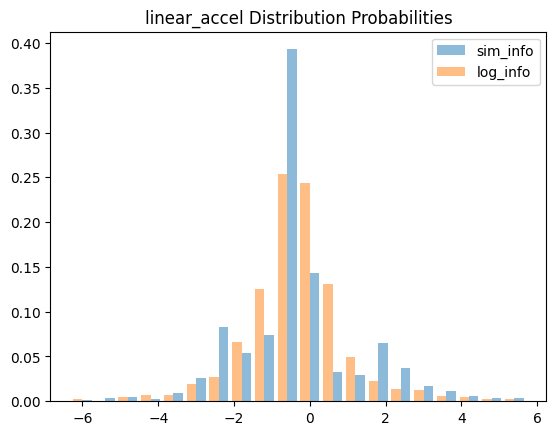

--------------------------------------------------

JS(linear_speed) = 0.27661526063579844


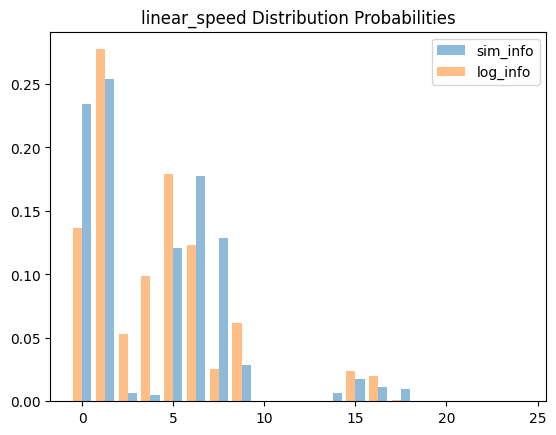

--------------------------------------------------

JS(yaw_speed) = 0.2283641280398373


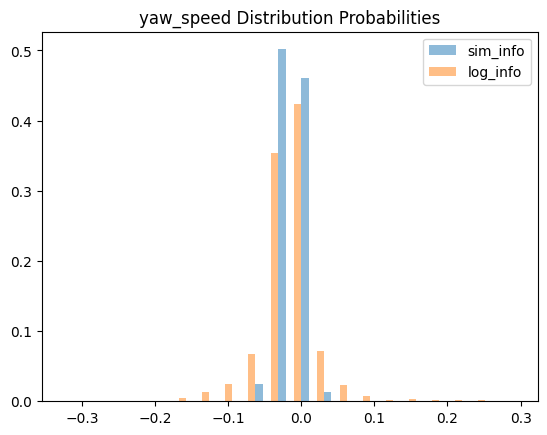

--------------------------------------------------

JS(yaw_accel) = 0.24607688603824115


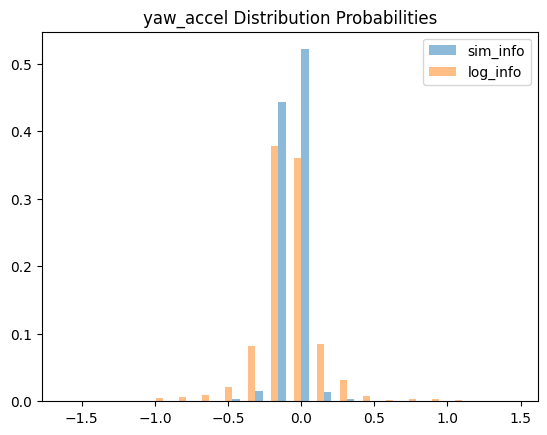

--------------------------------------------------

JS(relative_distance) = 0.19226603182827512


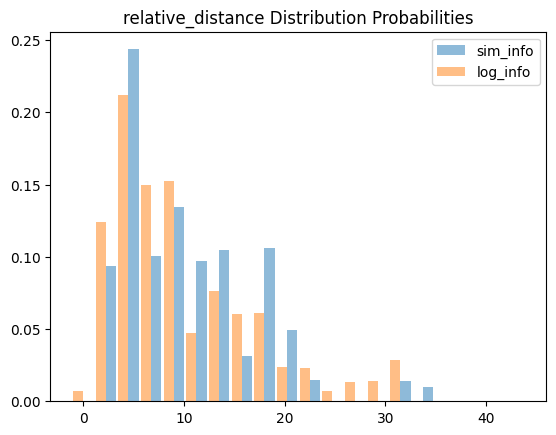

--------------------------------------------------

JS(relative_speed) = 0.2131388905269157


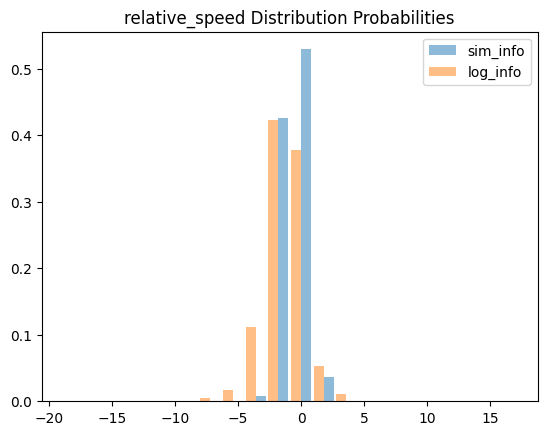

--------------------------------------------------

JS(relative_accel) = 0.31602216885915074


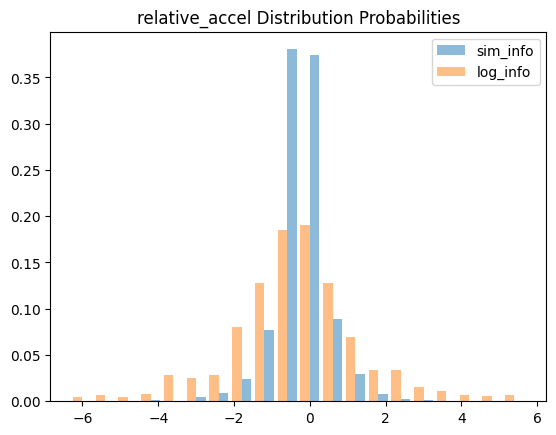

--------------------------------------------------

JS(ttc) = 0.12660041376597314


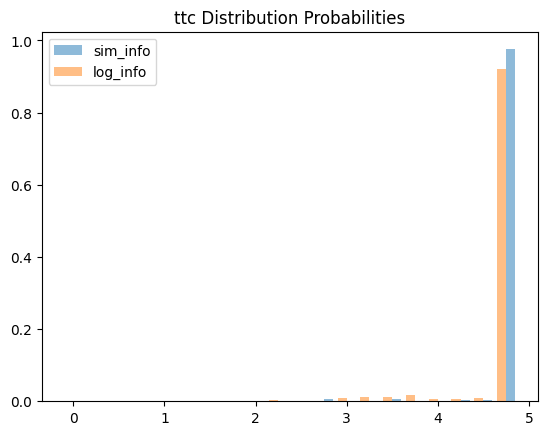

--------------------------------------------------



In [11]:
real_metrics.compute_js_divergence(
    method='histogram',  #! kernel为核密度估计，histogram为直方图估计
    plot=True            #! 是否打印结果
)

In [12]:
real_metrics.js_divergence

{'linear_accel': 0.22865635051884095,
 'linear_speed': 0.27661526063579844,
 'yaw_speed': 0.2283641280398373,
 'yaw_accel': 0.24607688603824115,
 'relative_distance': 0.19226603182827512,
 'relative_speed': 0.2131388905269157,
 'relative_accel': 0.31602216885915074,
 'ttc': 0.12660041376597314}

# 可视化模块

In [16]:
# 从数据集加载场景
import pickle
from waymo_open_dataset.protos import scenario_pb2

with open(rf"data/process/val_scenarios/{batch.scenario_id[0]}.pickle", "rb") as handle:
    scenario = scenario_pb2.Scenario.FromString(bytes.fromhex(pickle.load(handle).hex()))

In [33]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Set matplotlib to jshtml so animations work with colab.
from matplotlib import rc
rc('animation', html='jshtml')

import numpy as np
from waymo_open_dataset.utils.sim_agents import visualizations

In [38]:
N, T, _ = pred['pred_traj'].shape
real_trajectory = pred['gt']
pred_trajectory = pred['pred_traj']

# 创建颜色表（每个物体使用不同颜色）
colors = plt.cm.viridis(torch.linspace(0, 1, N))  # 使用viridis颜色表

# 设置绘图环境
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title(f"scene {batch.scenario_id[0]}")
visualizations.add_map(ax, scenario)

alpha_values = np.linspace(0.1, 0.8, 8) 
# 初始化真实轨迹和预测轨迹的绘制对象
# real_lines = [ax.plot([], [], 'o', color=colors[i], markersize=3, alpha=0.3)[0] for i in range(N)]  # 真实轨迹
pred_lines = [ax.plot([], [], 'o', color=colors[i], markersize=3, alpha=0.8)[0] for i in range(N)]  # 预测轨迹

# 更新函数，每一帧调用一次
def update(frame):
    for i in range(N):
        # 真实轨迹更新
        # real_lines[i].set_data(real_trajectory[i, frame, 0], real_trajectory[i, frame, 1])
        # 预测轨迹更新
        pred_lines[i].set_data(pred_trajectory[i, max(frame-8, 0):frame+1, 0], pred_trajectory[i, max(frame-8, 0): frame+1, 1])
    # return real_lines + pred_lines
    return pred_lines

# 创建动画
ani = FuncAnimation(fig, update, frames=T, interval=100, blit=True)

# 保存为gif
ani.save(f"videos/20241001_epoch02/{batch.scenario_id[0]}.gif", writer=PillowWriter(fps=10))

# 如果你想保存为mp4格式，可以使用以下代码：
# ani.save("trajectories_animation.mp4", writer='ffmpeg', fps=5)

ani

# 运行tensorboard

In [2]:
!tensorboard --logdir=/home/yangyh408/codes/SMART/lightning_logs/version_4  

2024-10-09 03:22:28.511446: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 03:22:28.532083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 03:22:29.226937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-09 03:22:29.228158: I tensorflow/comp

# ONNX导出测试

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import HeteroData
import torch_geometric

In [199]:
class SimpleHeteroModel(torch.nn.Module):
    def __init__(self):
        super(SimpleHeteroModel, self).__init__()
        self.conv1 = GCNConv(8, 16)
        self.conv2 = GCNConv(16, 32)

    def forward(self, data: HeteroData):
        x, edge_index = data['node_type'].x, data['node_type', 'to', 'node_type'].edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [164]:
def hetero_data_to_tensor_tuple(data: HeteroData):
    tensor_list = []
    for node_type, node_data in data.node_items():
        for key, tensor in node_data.items():
            tensor_list.append(tensor)
    for edge_type, edge_data in data.edge_items():
        for key, tensor in edge_data.items():
            tensor_list.append(tensor)
    return tuple(tensor_list)

In [165]:
class SimpleHeteroONNXWrapper(torch.nn.Module):
    def __init__(self, model, example_data):
        super(SimpleHeteroONNXWrapper, self).__init__()
        self.model = model
        self.example_data_structure = example_data

    def forward(self, *tensor_inputs):
        data = self.convert_to_hetero_data(tensor_inputs)
        return self.model(data)

    def convert_to_hetero_data(self, tensor_inputs):
        data = HeteroData()
        idx = 0
        for node_type, node_data in self.example_data_structure.node_items():
            for key in node_data.keys():
                setattr(data[node_type], key, tensor_inputs[idx])
                idx += 1
        for edge_type, edge_data in self.example_data_structure.edge_items():
            for key in edge_data.keys():
                setattr(data[edge_type], key, tensor_inputs[idx])
                idx += 1
        return data

In [166]:
example_data = HeteroData()
example_data['node_type'].x = torch.randn((10, 8))  # 10 nodes with 8 features each
example_data['node_type', 'to', 'node_type'].edge_index = torch.randint(0, 10, (2, 20))  # 20 edges

# 初始化并加载模型
simple_model = SimpleHeteroModel()
onnx_wrapper = SimpleHeteroONNXWrapper(simple_model, example_data)

# 获取示例输入
example_inputs = hetero_data_to_tensor_tuple(example_data)

In [167]:
# 导出到 ONNX 格式
torch.onnx.export(
    onnx_wrapper,
    example_inputs,
    "simple_hetero_model.onnx",
    input_names=[f"input_{i}" for i in range(len(example_inputs))],
    output_names=["output"],
    dynamic_axes={f"input_{i}": {0: "batch_size"} for i in range(len(example_inputs))},
    opset_version=11,
    do_constant_folding=True
)

/home/yangyh408/anaconda3/envs/smart/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:4137: UserWarning: Exporting aten::index operator with indices of type Byte. Only 1-D indices are supported. In any other case, this will produce an incorrect ONNX graph.
  warnings.warn(


In [184]:
import torch
import numpy as np
import onnxruntime

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 定义示例输入
example_data = HeteroData()
example_data['node_type'].x = torch.randn((10, 8))  # 10 nodes with 8 features each
example_data['node_type', 'to', 'node_type'].edge_index = torch.randint(0, 10, (2, 20))  # 20 edges
example_inputs = hetero_data_to_tensor_tuple(example_data)

# 导出模型到 ONNX
torch.onnx.export(
    onnx_wrapper,
    example_inputs,
    "simple_hetero_model.onnx",
    input_names=[f"input_{i}" for i in range(len(example_inputs))],
    output_names=["output"],
    # dynamic_axes={f"input_{i}": {0: "batch_size"} for i in range(len(example_inputs))},
    opset_version=11,
    do_constant_folding=True
)

# 设置种子后再计算 PyTorch 输出
set_seed(42)
onnx_wrapper.eval()
with torch.no_grad():
    pytorch_output = onnx_wrapper(*example_inputs)

# 创建 ONNX 运行时会话
session = onnxruntime.InferenceSession("simple_hetero_model.onnx")
# 准备 ONNX 输入字典
onnx_input_dict = {f"input_{i}": tensor.detach().cpu().numpy() for i, tensor in enumerate(example_inputs)}
# 进行推理
onnx_output = session.run(None, onnx_input_dict)

# 将 PyTorch 输出转换为 NumPy 数组
pytorch_output_np = pytorch_output.detach().cpu().numpy()

# 检查 ONNX 和 PyTorch 输出的一致性
if np.allclose(onnx_output[0], pytorch_output_np, rtol=1e-3, atol=1e-5):
    print("ONNX and PyTorch outputs are consistent!")
else:
    print("Outputs differ between ONNX and PyTorch.")



Outputs differ between ONNX and PyTorch.


In [185]:
# 设置种子后再计算 PyTorch 输出
set_seed(42)
onnx_wrapper.eval()
with torch.no_grad():
    pytorch_output = onnx_wrapper(*example_inputs)
pytorch_output

tensor([[ 5.9671e-03, -1.9189e-01, -6.9430e-02,  3.9924e-02, -3.6220e-01,
         -2.1811e-01,  4.5647e-02,  1.8320e-01, -5.4718e-01, -3.4505e-01,
         -5.4831e-02,  1.9662e-02,  3.4358e-01, -2.8479e-01, -4.1332e-01,
          6.6295e-02,  6.3223e-02, -6.4044e-02,  1.1502e-01, -3.1252e-01,
          1.6202e-01,  1.8319e-04,  2.8605e-01, -8.1646e-02,  1.5195e-01,
         -7.0474e-03,  7.0387e-02,  8.6505e-02, -2.0905e-01,  1.9084e-02,
         -3.8809e-01, -2.1900e-02],
        [ 3.8890e-02, -2.5185e-01, -7.5222e-03,  3.3121e-02, -5.6432e-01,
         -1.9489e-01,  9.1773e-02,  2.7449e-01, -7.3359e-01, -4.6020e-01,
         -1.4594e-02,  3.4651e-02,  4.8144e-01, -3.4890e-01, -5.6609e-01,
          1.0663e-01,  7.6585e-03, -2.1998e-02,  1.9337e-01, -4.2445e-01,
          1.5362e-01,  6.8759e-02,  3.2649e-01, -1.2942e-01,  2.1101e-01,
         -7.9258e-02,  1.3842e-02,  1.2967e-01, -2.3054e-01,  4.2308e-02,
         -5.8879e-01,  4.7110e-02],
        [ 3.6821e-01,  1.3224e-02,  1.63

In [198]:
# 创建 ONNX 运行时会话
session = onnxruntime.InferenceSession("simple_hetero_model.onnx")
# 准备 ONNX 输入字典
onnx_input_dict = {f"input_{i}": tensor.detach().cpu().numpy() for i, tensor in enumerate(example_inputs)}
# 进行推理
onnx_output = session.run(None, onnx_input_dict)
onnx_output

[array([[-1.35891259e+00,  5.36735356e-01, -6.13924086e-01,
          7.50556767e-01,  1.83346078e-01, -1.07995105e+00,
         -9.31967318e-01, -1.16492771e-01, -1.24236822e+00,
          3.25781107e-02, -2.62718409e-01,  3.10892224e-01,
         -7.04178810e-02, -5.20153120e-02, -1.48391291e-01,
         -1.98711112e-01, -1.21454105e-01, -2.99240232e-01,
          4.57712471e-01, -2.31490329e-01,  1.22253311e+00,
          1.42108306e-01,  5.70460021e-01, -8.04444849e-01,
         -1.72228441e-01,  2.76746958e-01,  1.36651039e+00,
          9.94035542e-01, -2.13111535e-01, -6.15865469e-01,
         -7.98087656e-01, -1.03146851e-01],
        [ 2.16662273e-01, -6.93499029e-01,  2.37550437e-01,
         -2.90292919e-01, -8.32642674e-01, -4.33061868e-01,
          7.78994784e-02,  9.73093361e-02, -6.21600449e-01,
         -4.54021901e-01,  5.19788042e-02,  2.37776831e-01,
          4.87441003e-01, -7.39624023e-01, -8.30098152e-01,
         -1.86424717e-01,  1.53111577e-01,  3.35395306e-

In [196]:
import onnx
model = onnx.load("simple_hetero_model.onnx")
print(onnx.helper.printable_graph(model.graph))

graph torch_jit (
  %input_0[FLOAT, 10x8]
  %input_1[INT64, 2x20]
) initializers (
  %model.conv1.bias[FLOAT, 16]
  %model.conv2.bias[FLOAT, 32]
  %onnx::ConstantOfShape_174[INT64, 1]
  %onnx::MatMul_175[FLOAT, 8x16]
  %onnx::Concat_176[INT64, 1]
  %onnx::Range_177[INT64, scalar]
  %onnx::Range_178[INT64, scalar]
  %onnx::MatMul_180[FLOAT, 16x32]
) {
  %onnx::ConstantOfShape_179 = Identity(%onnx::ConstantOfShape_174)
  %onnx::Gather_6 = Constant[value = <Scalar Tensor []>]()
  %onnx::Equal_7 = Gather[axis = 0](%input_1, %onnx::Gather_6)
  %onnx::Gather_8 = Constant[value = <Scalar Tensor []>]()
  %onnx::Equal_9 = Gather[axis = 0](%input_1, %onnx::Gather_8)
  %onnx::Not_10 = Equal(%onnx::Equal_7, %onnx::Equal_9)
  %onnx::NonZero_11 = Not(%onnx::Not_10)
  %onnx::Expand_12 = Constant[value = <Tensor>]()
  %onnx::Tile_13 = Constant[value = <Tensor>]()
  %onnx::Expand_15 = ConstantOfShape[value = <Tensor>](%onnx::ConstantOfShape_174)
  %onnx::Tile_16 = Expand(%onnx::Expand_12, %onnx::Expand

In [195]:
import onnx.numpy_helper as numpy_helper

for init in model.graph.initializer:
    param_array = numpy_helper.to_array(init)
    print(f"Name: {init.name}, Values: {param_array}")
    print("="*30)

Name: model.conv1.bias, Values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Name: model.conv2.bias, Values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Name: onnx::ConstantOfShape_174, Values: [2]
Name: onnx::MatMul_175, Values: [[ 0.08430463  0.07292747  0.13709778  0.18835723  0.15080178 -0.01098573
  -0.22651398  0.00750333  0.12228078 -0.44691044  0.07745296 -0.08511984
   0.41364604 -0.13348919  0.03048247  0.07327414]
 [-0.13658506 -0.15349644  0.11321563  0.19252414  0.27013606  0.0231474
   0.2099815   0.30341822 -0.33355838  0.2500075   0.29419243 -0.06044006
  -0.10235846  0.12096488  0.17421293 -0.43935627]
 [ 0.39175922 -0.25813073  0.2055468   0.3966567   0.4374563   0.06334358
   0.00453454  0.03228521  0.17409343 -0.45000595  0.02972579  0.48894006
   0.23552275 -0.35530734 -0.31420207 -0.01696336]
 [ 0.30040365 -0.16077352  0.08581626  0.10178638 -0.15815586  0.18620914
  -0.07273233  0.03997612 -0.29986674 -0

In [194]:
import torchvision.models as models
torch.set_printoptions(precision=8)
state_dict = onnx_wrapper.state_dict()
for name, param in state_dict.items():
    print(f"Parameter Name: {name}")
    print(f"Shape: {param.shape}")
    print(f"Values: {param}")
    print("="*50)

Parameter Name: model.conv1.bias
Shape: torch.Size([16])
Values: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Parameter Name: model.conv1.lin.weight
Shape: torch.Size([16, 8])
Values: tensor([[ 0.08430463, -0.13658506,  0.39175922,  0.30040365, -0.31057686,
         -0.04074073, -0.04799688, -0.31336540],
        [ 0.07292747, -0.15349644, -0.25813073, -0.16077352, -0.17827427,
          0.47832000,  0.19178599,  0.49205661],
        [ 0.13709778,  0.11321563,  0.20554680,  0.08581626, -0.39238572,
         -0.29567677, -0.12113929,  0.00751662],
        [ 0.18835723,  0.19252414,  0.39665669,  0.10178638, -0.17064661,
         -0.37601316, -0.36620533, -0.29866874],
        [ 0.15080178,  0.27013606,  0.43745631, -0.15815586, -0.03944147,
         -0.14848173, -0.00182700,  0.16050071],
        [-0.01098573,  0.02314740,  0.06334358,  0.18620914, -0.15170068,
         -0.29814881,  0.11796230, -0.05920279],
        [-0.22651398,  0.20998150,  0.00453454, -0

# 其他

In [11]:
traj_token_path = "smart/tokens/cluster_frame_5_2048.pkl"
traj_token_data = pickle.load(open(traj_token_path, 'rb'))

In [13]:
traj_token_data.keys()

dict_keys(['token', 'traj', 'token_all'])

In [21]:
traj_token_data['token']['veh'].shape

(2048, 4, 2)

In [17]:
traj_token_data['traj']['veh'].shape

(2048, 6, 3)

In [19]:
traj_token_data['token_all']['veh'].shape

(2048, 6, 4, 2)

In [24]:
print(traj_token_data['token']['veh'][0])
print(traj_token_data['traj']['veh'][0])
print(traj_token_data['token_all']['veh'][0])

[[13.07768465  0.87615351]
 [13.05234569 -1.12368592]
 [ 8.25273107 -1.06287242]
 [ 8.27807003  0.93696701]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18193674e+00 -1.01901311e-02 -2.53396365e-03]
 [ 4.36681175e+00 -2.77502462e-02 -5.06792730e-03]
 [ 6.55324173e+00 -4.83181626e-02 -7.60189118e-03]
 [ 8.70484447e+00 -7.06782714e-02 -1.01358546e-02]
 [ 1.06652079e+01 -9.33594555e-02 -1.26698185e-02]]
[[[ 2.4         1.        ]
  [ 2.4        -1.        ]
  [-2.4        -1.        ]
  [-2.4         1.        ]]

 [[ 4.584463    0.98372513]
  [ 4.5793953  -1.0162684 ]
  [-0.22058943 -1.0041054 ]
  [-0.21552151  0.9958882 ]]

 [[ 6.7718487   0.96007395]
  [ 6.761713   -1.0399004 ]
  [ 1.9617745  -1.0155745 ]
  [ 1.9719102   0.9843999 ]]

 [[ 8.960774    0.93340856]
  [ 8.945571   -1.0665337 ]
  [ 4.1457095  -1.0300449 ]
  [ 4.160913    0.96989733]]

 [[11.114857    0.9049447 ]
  [11.094585   -1.0949526 ]
  [ 6.294832   -1.0463012 ]
  [ 6.3151035   0.953596  ]]

 [[13.077684  

In [25]:
map_token_path = "smart/tokens/map_traj_token5.pkl"
map_token_data = pickle.load(open(traj_token_path, 'rb'))

In [30]:
map_token_data['token']['veh'].shape

(2048, 4, 2)